**Task 1**

In [12]:
import networkx as nx
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

G = nx.Graph()

with open('ca-AstroPh.txt', 'r') as f:
    for line in f:
        nodes = line.strip().split()
        if len(nodes) == 2:
            node1, node2 = nodes[0], nodes[1]
            if G.has_edge(node1, node2):
                G[node1][node2]["weight"] += 1
            else:
                G.add_edge(node1, node2, weight=1)

In [13]:
features = {}

for node in G.nodes():
    egonet = nx.ego_graph(G, node, radius=1)

    Ni = len(list(egonet.neighbors(node)))

    Ei = egonet.size()

    Wi = egonet.size(weight='weight')

    adj_matrix = nx.adjacency_matrix(egonet, weight='weight').todense()
    if adj_matrix.shape[0] > 0:
        eigenvalues = np.linalg.eigvalsh(adj_matrix)
        lambda_w_i = np.max(eigenvalues)
    else:
        lambda_w_i = 0

    features[node] = {'Ni': Ni, 'Ei': Ei, 'Wi': Wi, 'lambda_w_i': lambda_w_i}

nx.set_node_attributes(G, features)

In [14]:
Ni_list = []
Ei_list = []
nodes_list = []

for node in G.nodes():
    Ni = G.nodes[node]['Ni']
    Ei = G.nodes[node]['Ei']
    if Ni > 0 and Ei > 0:
        Ni_list.append(Ni)
        Ei_list.append(Ei)
        nodes_list.append(node)

log_Ni = np.log(Ni_list).reshape(-1, 1)
log_Ei = np.log(Ei_list)

model = LinearRegression()
model.fit(log_Ni, log_Ei)

C = np.exp(model.intercept_)
theta = model.coef_[0]

scores = {}
for i, node in enumerate(nodes_list):
    Ni = Ni_list[i]
    Ei = Ei_list[i]

    y_pred = C * (Ni ** theta)

    numerator = max(Ei, y_pred)
    denominator = min(Ei, y_pred)

    score = (numerator / denominator) * np.log(abs(Ei - y_pred) + 1)
    scores[node] = score

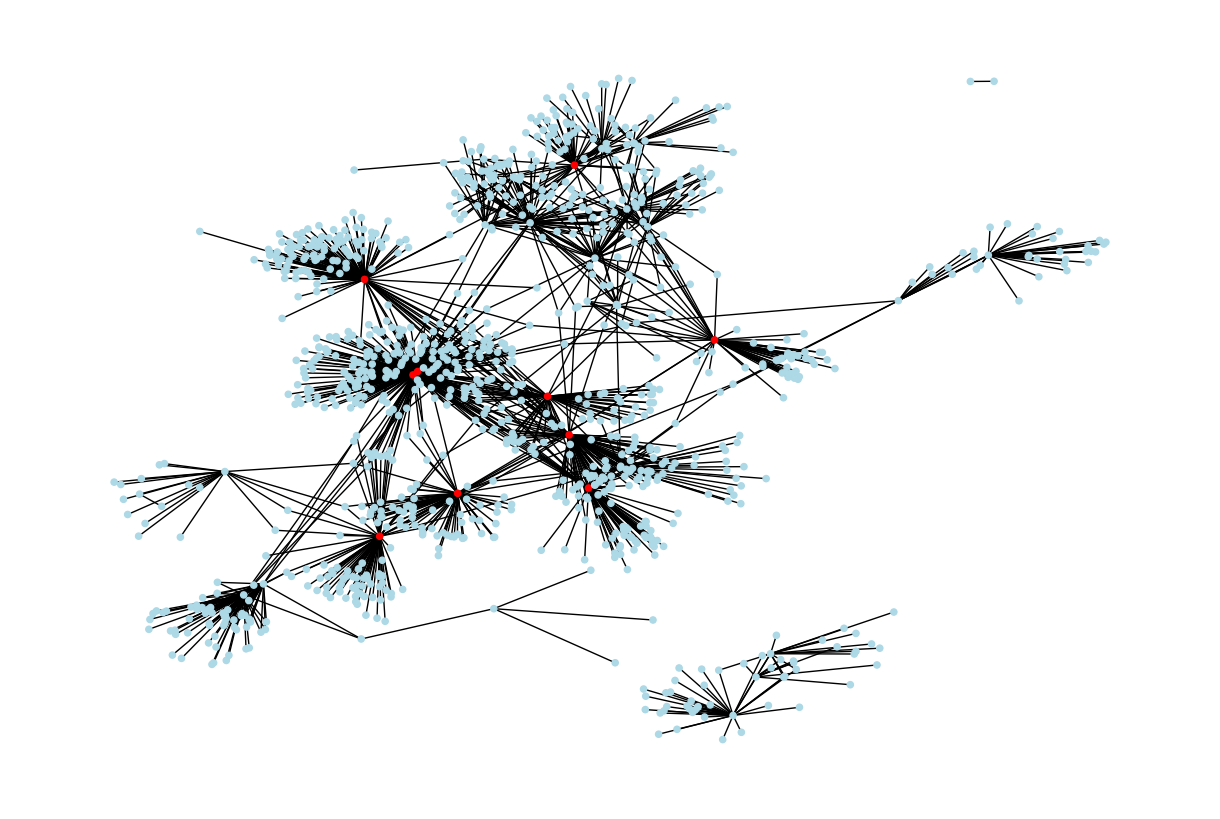

In [15]:
G_subset = nx.Graph()

with open('ca-AstroPh.txt', 'r') as f:
    for i, line in enumerate(f):
        if i >= 1500:
            break
        nodes = line.strip().split()
        if len(nodes) == 2:
            node1, node2 = nodes[0], nodes[1]
            if G_subset.has_edge(node1, node2):
                G_subset[node1][node2]["weight"] += 1
            else:
                G_subset.add_edge(node1, node2, weight=1)

features_subset = {}
for node in G_subset.nodes():
    egonet = nx.ego_graph(G_subset, node, radius=1)
    Ni = len(list(egonet.neighbors(node)))
    Ei = egonet.size()
    Wi = egonet.size(weight='weight')
    adj_matrix = nx.adjacency_matrix(egonet, weight='weight').todense()
    if adj_matrix.shape[0] > 0:
        eigenvalues = np.linalg.eigvalsh(adj_matrix)
        lambda_w_i = np.max(eigenvalues)
    else:
        lambda_w_i = 0
    features_subset[node] = {'Ni': Ni, 'Ei': Ei, 'Wi': Wi, 'lambda_w_i': lambda_w_i}

nx.set_node_attributes(G_subset, features_subset)

Ni_subset = []
Ei_subset = []
nodes_subset = []

for node in G_subset.nodes():
    Ni = G_subset.nodes[node]['Ni']
    Ei = G_subset.nodes[node]['Ei']
    if Ni > 0 and Ei > 0:
        Ni_subset.append(Ni)
        Ei_subset.append(Ei)
        nodes_subset.append(node)

log_Ni_subset = np.log(Ni_subset).reshape(-1, 1)
log_Ei_subset = np.log(Ei_subset)

model_subset = LinearRegression()
model_subset.fit(log_Ni_subset, log_Ei_subset)

C_subset = np.exp(model_subset.intercept_)
theta_subset = model_subset.coef_[0]

scores_subset = {}
for i, node in enumerate(nodes_subset):
    Ni = Ni_subset[i]
    Ei = Ei_subset[i]
    y_pred = C_subset * (Ni ** theta_subset)
    numerator = max(Ei, y_pred)
    denominator = min(Ei, y_pred)
    score = (numerator / denominator) * np.log(abs(Ei - y_pred) + 1)
    scores_subset[node] = score

sorted_scores_subset = sorted(scores_subset.items(), key=lambda x: x[1], reverse=True)
top_10_nodes = set([node for node, score in sorted_scores_subset[:10]])

node_colors = []
for node in G_subset.nodes():
    if node in top_10_nodes:
        node_colors.append('red')
    else:
        node_colors.append('lightblue')

plt.figure(figsize=(12, 8))
nx.draw(G_subset, node_color=node_colors, node_size=20, with_labels=False)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


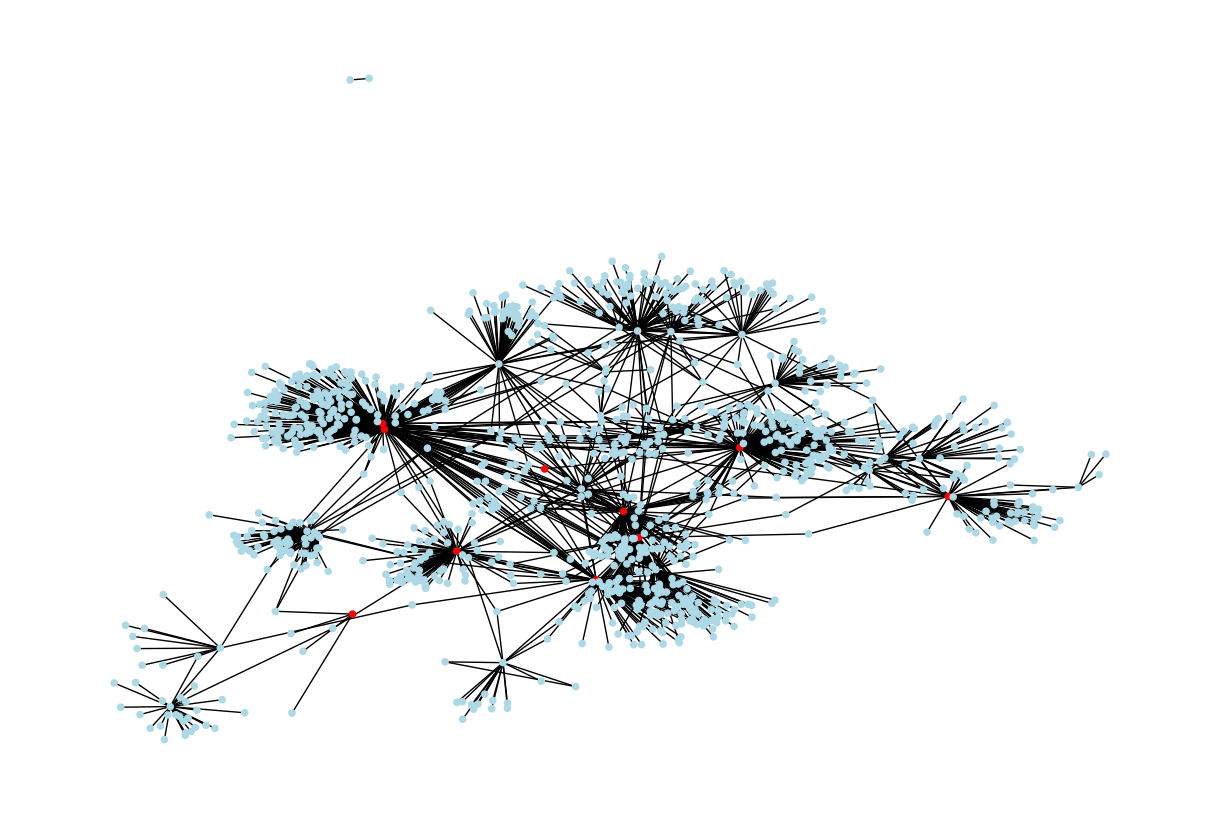

In [16]:
X_features_subset = np.array([[Ei_subset[i], Ni_subset[i]] for i in range(len(nodes_subset))])

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof.fit_predict(X_features_subset)
lof_scores_subset = -lof.negative_outlier_factor_

score_values_subset = np.array([scores_subset[node] for node in nodes_subset])
normalized_scores_subset = (score_values_subset - score_values_subset.min()) / (score_values_subset.max() - score_values_subset.min())
normalized_lof_subset = (lof_scores_subset - lof_scores_subset.min()) / (lof_scores_subset.max() - lof_scores_subset.min())

combined_scores_subset = {}
for i, node in enumerate(nodes_subset):
    combined_scores_subset[node] = normalized_scores_subset[i] + normalized_lof_subset[i]

sorted_combined_subset = sorted(combined_scores_subset.items(), key=lambda x: x[1], reverse=True)
top_10_combined = set([node for node, score in sorted_combined_subset[:10]])

node_colors_combined = []
for node in G_subset.nodes():
    if node in top_10_combined:
        node_colors_combined.append('red')
    else:
        node_colors_combined.append('lightblue')

plt.figure(figsize=(12, 8))
nx.draw(G_subset, node_color=node_colors_combined, node_size=20, with_labels=False)
plt.show()

**Task 2**

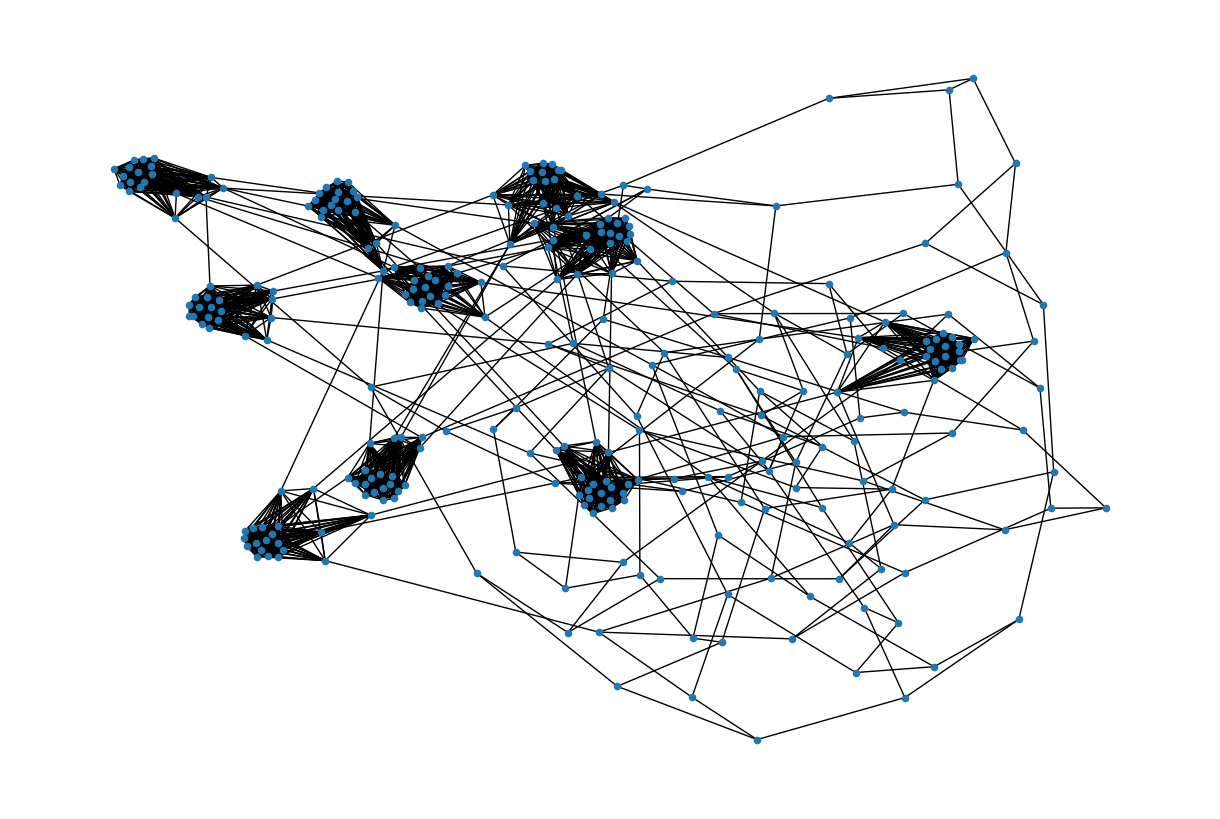

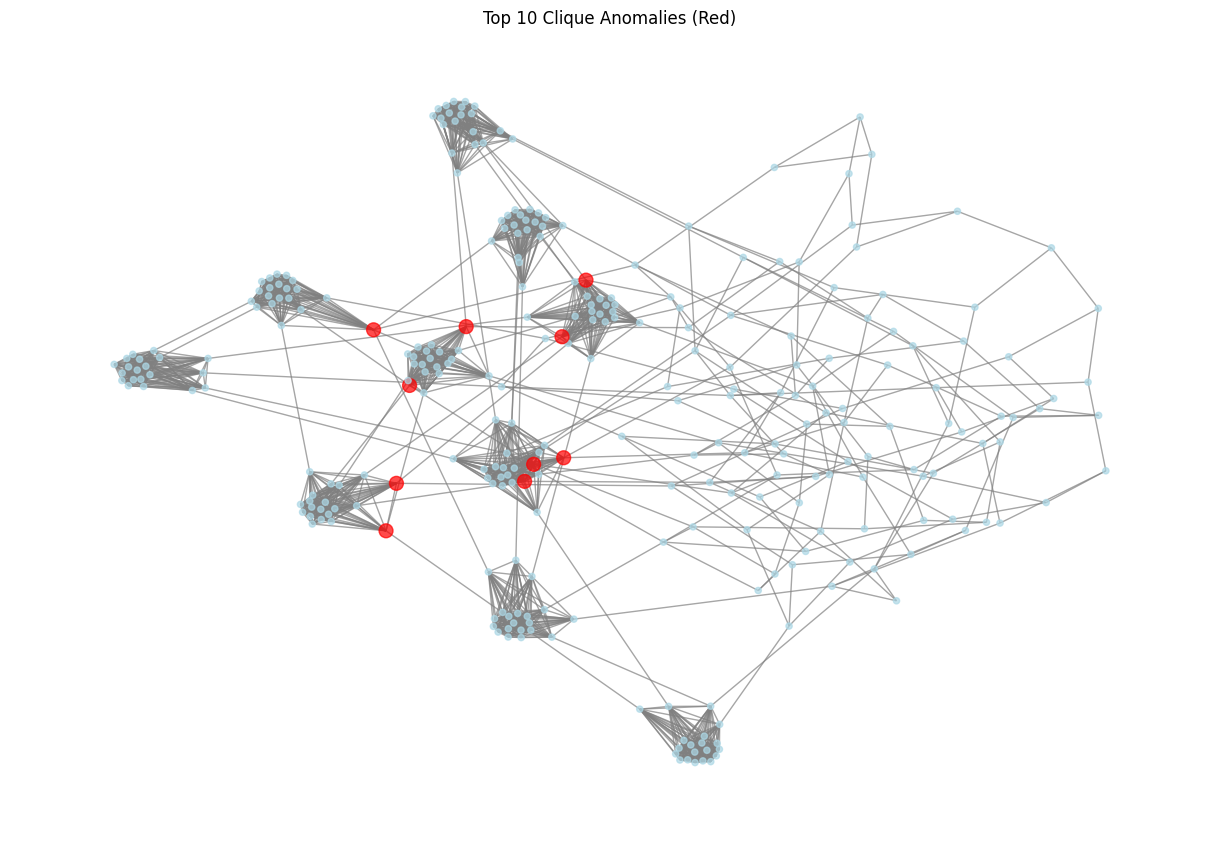

In [17]:
import random

G1 = nx.random_regular_graph(3, 100)
G2 = nx.connected_caveman_graph(10, 20)

G_merged = nx.union(G1, G2, rename=('G1-', 'G2-'))

nodes_list_merged = list(G_merged.nodes())
for _ in range(50):
    node1 = random.choice(nodes_list_merged)
    node2 = random.choice(nodes_list_merged)
    if node1 != node2:
        G_merged.add_edge(node1, node2)

plt.figure(figsize=(12, 8))
nx.draw(G_merged, node_size=20, with_labels=False)
plt.show()

features_merged = {}
for node in G_merged.nodes():
    egonet = nx.ego_graph(G_merged, node, radius=1)
    Ni = len(list(egonet.neighbors(node)))
    Ei = egonet.size()
    features_merged[node] = {'Ni': Ni, 'Ei': Ei}

nx.set_node_attributes(G_merged, features_merged)

Ni_merged = []
Ei_merged = []
nodes_merged = []

for node in G_merged.nodes():
    Ni = G_merged.nodes[node]['Ni']
    Ei = G_merged.nodes[node]['Ei']
    if Ni > 0 and Ei > 0:
        Ni_merged.append(Ni)
        Ei_merged.append(Ei)
        nodes_merged.append(node)

log_Ni_merged = np.log(Ni_merged).reshape(-1, 1)
log_Ei_merged = np.log(Ei_merged)

model_merged = LinearRegression()
model_merged.fit(log_Ni_merged, log_Ei_merged)

C_merged = np.exp(model_merged.intercept_)
theta_merged = model_merged.coef_[0]

scores_merged = {}
for i, node in enumerate(nodes_merged):
    Ni = Ni_merged[i]
    Ei = Ei_merged[i]
    y_pred = C_merged * (Ni ** theta_merged)
    numerator = max(Ei, y_pred)
    denominator = min(Ei, y_pred)
    score = (numerator / denominator) * np.log(abs(Ei - y_pred) + 1)
    scores_merged[node] = score

sorted_scores_merged = sorted(scores_merged.items(), key=lambda x: x[1], reverse=True)
top_10_cliques = [node for node, score in sorted_scores_merged[:10]]

node_colors_cliques = []
node_sizes = []
for node in G_merged.nodes():
    if node in top_10_cliques:
        node_colors_cliques.append('red')
        node_sizes.append(100)
    else:
        node_colors_cliques.append('lightblue')
        node_sizes.append(20)

plt.figure(figsize=(12, 8))
nx.draw(G_merged, node_color=node_colors_cliques, node_size=node_sizes, with_labels=False, edge_color='gray', alpha=0.7)
plt.title('Top 10 Clique Anomalies (Red)')
plt.show()

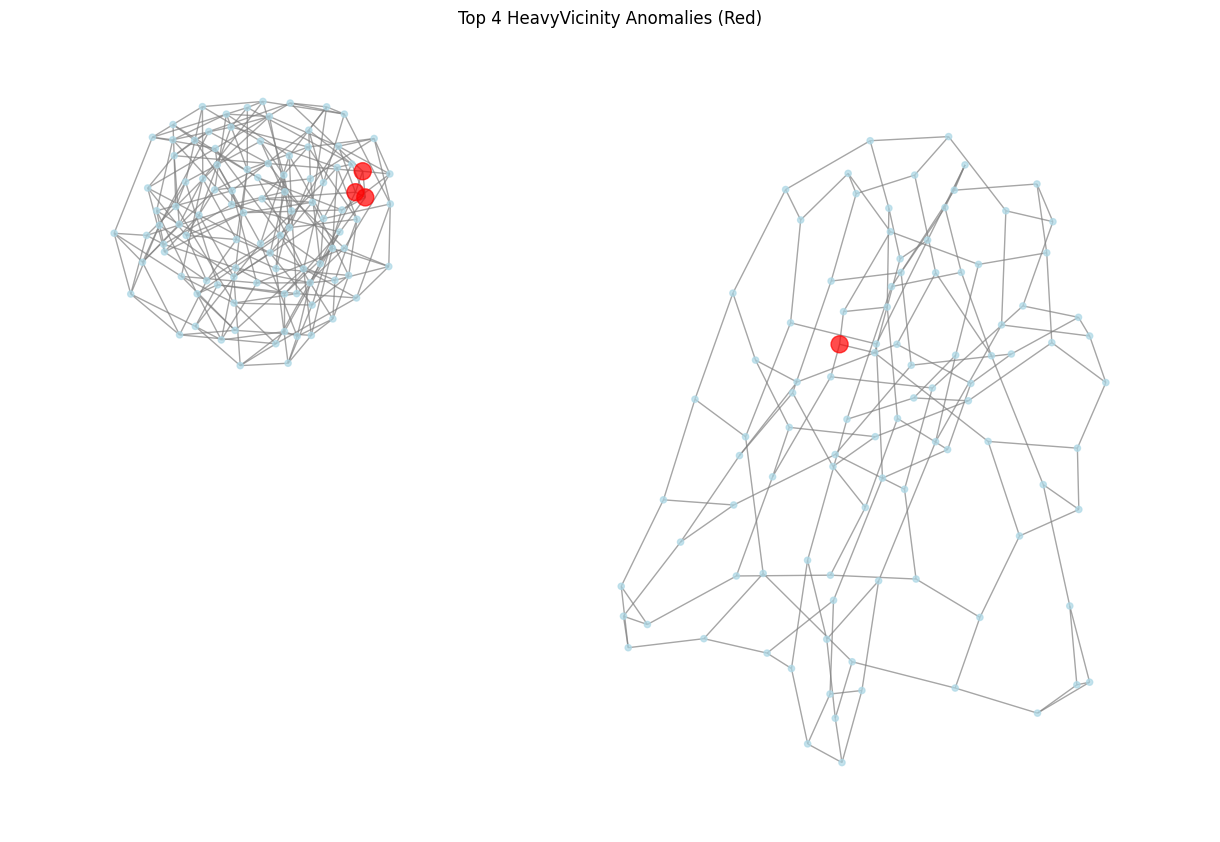

In [18]:
G3 = nx.random_regular_graph(3, 100)
G4 = nx.random_regular_graph(5, 100)

G_heavy = nx.union(G3, G4, rename=('G3-', 'G4-'))

for edge in G_heavy.edges():
    G_heavy.add_edge(edge[0], edge[1], weight=1)

all_nodes = list(G_heavy.nodes())
random_nodes = random.sample(all_nodes, 2)

for random_node in random_nodes:
    egonet = nx.ego_graph(G_heavy, random_node, radius=1)
    for edge in egonet.edges():
        G_heavy[edge[0]][edge[1]]["weight"] += 10

features_heavy = {}
for node in G_heavy.nodes():
    egonet = nx.ego_graph(G_heavy, node, radius=1)
    Ei = egonet.size()
    Wi = egonet.size(weight='weight')
    features_heavy[node] = {'Ei': Ei, 'Wi': Wi}

nx.set_node_attributes(G_heavy, features_heavy)

Wi_list = []
Ei_list_heavy = []
nodes_heavy = []

for node in G_heavy.nodes():
    Ei = G_heavy.nodes[node]['Ei']
    Wi = G_heavy.nodes[node]['Wi']
    if Ei > 0 and Wi > 0:
        Wi_list.append(Wi)
        Ei_list_heavy.append(Ei)
        nodes_heavy.append(node)

log_Ei_heavy = np.log(Ei_list_heavy).reshape(-1, 1)
log_Wi = np.log(Wi_list)

model_heavy = LinearRegression()
model_heavy.fit(log_Ei_heavy, log_Wi)

C_heavy = np.exp(model_heavy.intercept_)
theta_heavy = model_heavy.coef_[0]

scores_heavy = {}
for i, node in enumerate(nodes_heavy):
    Ei = Ei_list_heavy[i]
    Wi = Wi_list[i]
    y_pred = C_heavy * (Ei ** theta_heavy)
    numerator = max(Wi, y_pred)
    denominator = min(Wi, y_pred)
    score = (numerator / denominator) * np.log(abs(Wi - y_pred) + 1)
    scores_heavy[node] = score

sorted_scores_heavy = sorted(scores_heavy.items(), key=lambda x: x[1], reverse=True)
top_4_heavy = [node for node, score in sorted_scores_heavy[:4]]

node_colors_heavy = []
node_sizes_heavy = []
for node in G_heavy.nodes():
    if node in top_4_heavy:
        node_colors_heavy.append('red')
        node_sizes_heavy.append(150)
    else:
        node_colors_heavy.append('lightblue')
        node_sizes_heavy.append(20)

plt.figure(figsize=(12, 8))
nx.draw(G_heavy, node_color=node_colors_heavy, node_size=node_sizes_heavy, with_labels=False, edge_color='gray', alpha=0.7)
plt.title('Top 4 HeavyVicinity Anomalies (Red)')
plt.show()

**Task 3**

In [1]:
%pip install torch-geometric

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ------------------------ --------------- 0.8/1.3 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 5.2 MB/s eta 0:00:00

   ---- ----------------------------------- 1/9 [propcache]
   ------------- -------------------------- 3/9 [frozenlist]
   ---------------------- ----------------- 5/9 [yarl]
   ---------------------- ----------------- 5/9 [yarl]
   ------------------------------- -------- 7/9 [aiohttp]
   ------------------------------- -------- 7/9 [aiohttp]
   ------------------------------- -------- 7/9 [aiohttp]
   ------------------------------- -------- 7/9 [aiohttp]
   ------------------------------- -------- 7/9 [aiohttp]
   ------------------------------- -------- 7/9 [aiohttp]
   ------------------------------- -------- 7/9 [aiohttp]
   ------------------------------- -------- 7/9 [aiohttp]
   --


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Encoder(nn.Module):
    def __init__(self, input_dim):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(input_dim, 128)
        self.conv2 = GCNConv(128, 64)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return x

class AttributeDecoder(nn.Module):
    def __init__(self, output_dim):
        super(AttributeDecoder, self).__init__()
        self.conv1 = GCNConv(64, 128)
        self.conv2 = GCNConv(128, output_dim)

    def forward(self, z, edge_index):
        x = self.conv1(z, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class StructureDecoder(nn.Module):
    def __init__(self):
        super(StructureDecoder, self).__init__()
        self.conv = GCNConv(64, 64)

    def forward(self, z, edge_index):
        z = self.conv(z, edge_index)
        z = F.relu(z)
        return torch.matmul(z, z.t())

class GraphAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(GraphAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim)
        self.attr_decoder = AttributeDecoder(input_dim)
        self.struct_decoder = StructureDecoder()

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        x_recon = self.attr_decoder(z, edge_index)
        a_recon = self.struct_decoder(z, edge_index)
        return x_recon, a_recon

C:\Users\User\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import scipy.io as sio
from torch_geometric.utils import from_scipy_sparse_matrix

data = sio.loadmat('ACM.mat')

attributes = data['Attributes'].toarray()
adjacency = data['Network']
labels = data['Label'].flatten()

edge_index, edge_weight = from_scipy_sparse_matrix(adjacency)

X = torch.FloatTensor(attributes)
A = torch.FloatTensor(adjacency.toarray())
y = torch.LongTensor(labels)

In [4]:
def custom_loss(X, X_recon, A, A_recon, alpha=0.8):
    attr_loss = torch.norm(X - X_recon, p='fro') ** 2
    struct_loss = torch.norm(A - A_recon, p='fro') ** 2
    total_loss = alpha * attr_loss + (1 - alpha) * struct_loss
    return total_loss

In [5]:
from sklearn.metrics import roc_auc_score

input_dim = X.shape[1]
model = GraphAutoencoder(input_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.004)

num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()

    X_recon, A_recon = model(X, edge_index)

    loss = custom_loss(X, X_recon, A, A_recon, alpha=0.8)

    loss.backward()

    optimizer.step()

    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            X_recon, A_recon = model(X, edge_index)

            attr_errors = torch.sum((X - X_recon) ** 2, dim=1).numpy()
            struct_errors = torch.sum((A - A_recon) ** 2, dim=1).numpy()

            reconstruction_errors = attr_errors + struct_errors

            y_true = (y > 0).numpy().astype(int)
            y_scores = reconstruction_errors

            roc_auc = roc_auc_score(y_true, y_scores)

            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, ROC AUC: {roc_auc:.4f}')

Epoch 5, Loss: 40043.7617, ROC AUC: 0.7472
Epoch 10, Loss: 39606.7695, ROC AUC: 0.7464
Epoch 15, Loss: 39618.4102, ROC AUC: 0.7464
Epoch 20, Loss: 39635.6367, ROC AUC: 0.7464
Epoch 25, Loss: 39649.7070, ROC AUC: 0.7464
Epoch 30, Loss: 39583.0430, ROC AUC: 0.7464
Epoch 35, Loss: 39627.8438, ROC AUC: 0.7464
Epoch 40, Loss: 39594.1250, ROC AUC: 0.7464
Epoch 45, Loss: 39581.7891, ROC AUC: 0.7465
Epoch 50, Loss: 39499.4141, ROC AUC: 0.7465
Epoch 55, Loss: 39475.7031, ROC AUC: 0.7465
Epoch 60, Loss: 39443.4844, ROC AUC: 0.7465
Epoch 65, Loss: 39432.4453, ROC AUC: 0.7466
Epoch 70, Loss: 39410.6016, ROC AUC: 0.7468
Epoch 75, Loss: 39365.5820, ROC AUC: 0.7469
Epoch 80, Loss: 39294.1875, ROC AUC: 0.7471
Epoch 85, Loss: 39200.2461, ROC AUC: 0.7472
Epoch 90, Loss: 39144.8672, ROC AUC: 0.7474
Epoch 95, Loss: 39071.1094, ROC AUC: 0.7476
Epoch 100, Loss: 39011.6875, ROC AUC: 0.7478
